In [7]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colorbar as mbar
import seaborn as sns

from scipy.ndimage import gaussian_filter as smooth

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from scipy.stats import permutation_test
from scipy.stats import mannwhitneyu as mnu
from scipy.stats import spearmanr as spearman
from scipy.stats import zscore
from scipy.stats import norm

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix as ConMat

from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

# Definitions

In [ ]:
def movavg(input, win=[], step=[]):
    '''
    Args:
        input: matrix of input data, with shape (Neurons,Stimuli,Timepoints)
        win:   size of the window for moving averge
        step:  step size for moving forward
    Returns:
        output:     matrix of output data, with shape (Neurons,Stimuli,Timepoints),
                    where Timepoints are following the moving average process
        timestamps: (N,) vector of timepoints, corresponding to the output data, 
                    where N is the number of timepoints following the moving average process
    '''

    if not win: win = input.shape[2] // 25
    if not step: step = win // 10
    
    bins = [np.arange(0,input.shape[2]-win+1,step), 
            np.arange(win, input.shape[2]+1, step)]
    
    nbins = np.array(bins).shape[1]
    output = np.nan * np.zeros((input.shape[0], input.shape[1], nbins))

    timestamps = []
    counter_bin = 0
    for bin_st, bin_end in tqdm(zip(bins[0],bins[1])):
        timestamps.append(np.nanmean([bin_st, bin_end]))
        output[:,:,counter_bin] = np.nanmean(input[:,:,bin_st:bin_end], axis=2)
        counter_bin += 1

    return output, np.array(timestamps)


def m_plot(input_data, colors, error_method='sem', smooth_win=0, labels=[], plot_title='', timepoints=[], figure_size=(8,3)):
    '''
    Args:
        input_data:   (N,M,T) matrix of input data, (Conditions,Samples,Timepoints)
        colors:       (N,4) matrix of colors for the generated plots in [R,G,B,FaceAlpha] format,
                      where N is the number of conditions. FaceAlpha in the scale=[0-255]
        error_method: variation metric ('sem' & 'std')
        smooth_win:   smoothing window
        
        labels:       (N,) list of labels for the generated plots, where N is the number of conditions
        plot_title:   title of the generated plot
        timepoints:   (N,) vaetor of timepoints
        figure_size:  two-item tuple containing width and height of the figure
    Returns:
        none
    '''

    colors = np.array(colors) / np.array(255)
    if not labels: labels=['']*len(input_data)
    timepoints = np.array(timepoints)
    if timepoints.size==0: timepoints = np.arange(0,input_data[0].shape[1])
    
    plt.figure(figsize=figure_size)
    # sns.set_style('darkgrid')
    for i,Cond in enumerate(input_data):
        data_ave = smooth(np.nanmean(Cond, axis=0), smooth_win, axes=0)
        data_std = smooth(np.nanstd(Cond, axis=0), smooth_win, axes=0)
        
        if error_method=='sem':
            error_up  = data_ave + (data_std / np.sqrt(Cond.shape[0]))
            error_low = data_ave - (data_std / np.sqrt(Cond.shape[0]))
        elif error_method=='std':
            error_up  = data_ave + data_std
            error_low = data_ave - data_std

        plt.fill_between(timepoints, error_up, error_low, color=colors[i], label='_nolegend_')
        plt.plot(timepoints, data_ave, color=colors[i,:3], lw=3, label=labels[i])
    
    ylim = plt.ylim()
    plt.fill_between([0, 80], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='gray', alpha=.2, edgecolor=None)
    plt.legend(frameon=False, fontsize=10)
    plt.title(plot_title)
    plt.tight_layout()


def rand_idx_gen(cyles, cat_inds, stim_num, replacement=False):
    '''
    Args:
        cyles:       number repetitions or cycles
        cat_inds:    (N,) list of indices in each category/condition, where N is the number of categories/conditions,
                     and each item in the list is a np.array of indices for that category/condition.
        stim_num:    number of samples for each category/condition
        replacement: if True, sampling will be with replacement
    Returns:
        idx_rand: (N,M) np.array of the generated random indices, (cyles,cat_inds*stim_num)
    '''
    np.random.seed(15)
    idx_rand = []

    for iCycle in range(cyles):
        tmp_rand_tdx = []
        for i,iCat in enumerate(cat_inds):
            tmp_rand_tdx = np.concatenate((tmp_rand_tdx, iCat[np.random.choice(iCat.shape[0], stim_num, replace=replacement)]), axis=0)
        idx_rand.append(tmp_rand_tdx)

    return np.array(idx_rand).astype('int')


def FindResp(input_data, time_points, base_time_idx, resp_win=[50,300], onset_method=1):
    '''
    Args:
        input_data:    (N,M) matrix of input data (Trials or Neurons or Repetitions, Timepoints)
        time_points:   (M,) vector for values of the time axis
        base_time_idx: indices corresponding to the baseline
        resp_win:      two-item list of acceptable time window of response, in ms, with respect to time_points
        onset_method:  method to calculate onset
    Returns:
        val_peak:   value of the peak response
        time_peak:  time of the peak response
        time_onset: time of the onset response
        time_sol:   solution time, i.e., difference of peak and onset times (peak time - onset time)
        nan_count:  list containing number of nans for peak and onset times [number onset nans, number of peak nans]
    '''
    
    thr_std_base = 3
    thr_peak = .2

    val_peak, time_peak, time_onset = [], [], []
    for i,rep in enumerate(input_data):
        tmp_time_peak = time_points[rep.argmax()]

        tmp_base_ave = np.nanmean(rep[base_time_idx])
        tmp_base_std = np.nanstd(rep[base_time_idx])
        bools = rep > tmp_base_ave + (thr_std_base*tmp_base_std)
        if bools.sum()>0: tmp_time_onset = time_points[bools][0]
        else: tmp_time_onset = np.nan

        if (tmp_time_peak>resp_win[0]) & (tmp_time_peak<resp_win[1]) & (tmp_time_onset>resp_win[0]) & (tmp_time_onset<resp_win[1]):
            val_peak.append(rep.max())
            time_peak.append(time_points[rep.argmax()])
            time_onset.append(time_points[bools][0])
        else:
            val_peak.append(np.nan)
            time_peak.append(np.nan)
            time_onset.append(np.nan)
    
    time_sol = np.array(time_peak) - np.array(time_onset)
    nan_count = [(np.isnan(time_peak)).sum(), (np.isnan(time_onset)).sum()]

    return np.array(val_peak), np.array(time_peak), np.array(time_onset), time_sol, nan_count


def comp_bs_dist(input_data, cycle_num=200):
    '''
    Args:
        input_data: (N,M) matrix of input data (Trials or Neurons or Repetitions, Timepoints)
        cycle_num:  number of repetitions
    Returns:
        bs_dist: (N,M) matrix containing bootstrapped data (repetitions, Timepoints)
    '''
    
    np.random.seed(15)
    bs_dist = np.zeros_like(input_data) * np.nan

    for iCycle in range(cycle_num):
        tmp_rand_idx = np.random.choice(cycle_num,cycle_num)
        bs_dist[iCycle] = np.nanmean(input_data[tmp_rand_idx], axis=0)

    return bs_dist


def comp_permute_p(data_dist_1, data_dist_2, permute_reps=100001):
    '''
    Args:
        data_dist_1: (N,) vector of data 1st distribution (Samples,)
        data_dist_2: (N,) vector of data 2nd distribution (Samples,)
        permute_reps:  number of repetitions for the permutation process
    Returns:
        p_val: two-tailed p-value of the permutation process for [data_dist_2 - data_dist_1]
    '''

    def tmp_test_stat(x, y, axis):
        return np.nanmean(x, axis=axis) - np.nanmean(y, axis=axis)
    
    p_val = np.nan
    p_val = permutation_test(data=(data_dist_2, data_dist_1), statistic=tmp_test_stat, vectorized=True, axis=0, random_state=15, n_resamples=permute_reps).pvalue

    return p_val


def compare_means_bs(vec1, vec2):
    '''
    Args:
        vec1: (N,) vector of data 1st distribution (Samples,)
        vec2: (N,) vector of data 2nd distribution (Samples,)
    Returns:
        p_val: two-tailed p-value for [data_dist_1 - data_dist_2]
    '''
    # if you want to use nanmean, nanvar, etc -> you should change the function in a way that NaN values do not contribute to length variables. 

    mean_diff = np.mean(vec1) - np.mean(vec2)
    pooled_sd = np.sqrt( (((vec1.shape[0] - 1) * np.var(vec1)) + ((vec2.shape[0] - 1) * np.var(vec2))) / (vec1.shape[0] + vec2.shape[0] - 2) )

    z_val = mean_diff / pooled_sd
    p_val = 2 * ( 1 -  norm.cdf(abs(z_val)) )

    return p_val
    


In [ ]:
# load data
FigDir = '../Results/classifier/'

FileDir_IT = '../Data/Resp_IT.mat'
temp_file_IT = loadmat(FileDir_IT)

FileDir_PFC = '../Data/Resp_PFC.mat'
temp_file_PFC = loadmat(FileDir_PFC)

# parameters
SmoothWin = 20
step = 1
time_base = 90 # formerly, it was set to 80

# load neural data
resp_itc, time_stamps  = movavg(temp_file_IT['resp_it'], SmoothWin, step)
resp_pfc, time_stamps  = movavg(temp_file_PFC['resp_pfc'], SmoothWin, step)
time_stamps -= time_base

# color
color_itc, color_pfc = [255, 187, 112, 80], [129, 104, 157, 80]
color_itc_n, color_pfc_n = [255/255, 187/255, 112/255, 80/255], [129/255, 104/255, 157/255, 80/255]
color_anim, color_fb = [198, 60, 81, 80], [82, 34, 88, 80]

# sub-sampling
cycle_num = 30
test_portion = .3

indc1_anim = np.arange(0,175,1)
indc2_anim = np.arange(175,335,1)
labels_anim = np.concatenate( (1*np.ones_like(indc1_anim).T, 2*np.ones_like(indc2_anim).T) )
idx_anim = np.concatenate( (indc1_anim.T, indc2_anim.T) )

indc1_fb = np.arange(0,35,1)
indc2_fb = np.arange(35,75,1)
labels_fb = np.concatenate( (1*np.ones_like(indc1_fb).T, 2*np.ones_like(indc2_fb).T) )
idx_fb = np.concatenate( (indc1_fb.T, indc2_fb.T) )

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [15]:
np.random.seed(15)

acc_itc_fb = np.zeros((cycle_num,resp_itc.shape[2])) * np.nan
acc_pfc_fb = np.copy(acc_itc_fb)
acc_itc_anim = np.copy(acc_itc_fb)
acc_pfc_anim = np.copy(acc_itc_fb)

for itime in tqdm(range(resp_itc.shape[2])):
    tmp_resp_itc_anim = resp_itc[:,idx_anim,itime].T
    tmp_resp_itc_fb   = resp_itc[:,idx_fb,itime].T
    tmp_resp_pfc_anim = resp_pfc[:,idx_anim,itime].T
    tmp_resp_pfc_fb   = resp_pfc[:,idx_fb,itime].T
    
    for icycle in range(cycle_num):
        X_trn, X_tst, y_trn, y_tst = tts(tmp_resp_itc_anim, labels_anim, test_size=test_portion)
        y_pred = LDA(shrinkage='auto', solver='eigen').fit(X_trn, y_trn).predict(X_tst)
        tp, _, _, tn = ConMat(y_tst, y_pred).ravel()
        acc_itc_anim[icycle,itime] = np.nanmean(((tp/(y_tst==1).sum()), (tn/(y_tst==2).sum()))) * 100

        X_trn, X_tst, y_trn, y_tst = tts(tmp_resp_itc_fb, labels_fb, test_size=test_portion)
        y_pred = LDA(shrinkage='auto', solver='eigen').fit(X_trn, y_trn).predict(X_tst)
        tp, _, _, tn = ConMat(y_tst, y_pred).ravel()
        acc_itc_fb[icycle,itime] = np.nanmean(((tp/(y_tst==1).sum()), (tn/(y_tst==2).sum()))) * 100

        X_trn, X_tst, y_trn, y_tst = tts(tmp_resp_pfc_anim, labels_anim, test_size=test_portion)
        y_pred = LDA(shrinkage='auto', solver='eigen').fit(X_trn, y_trn).predict(X_tst)
        tp, _, _, tn = ConMat(y_tst, y_pred).ravel()
        acc_pfc_anim[icycle,itime] = np.nanmean(((tp/(y_tst==1).sum()), (tn/(y_tst==2).sum()))) * 100

        X_trn, X_tst, y_trn, y_tst = tts(tmp_resp_pfc_fb, labels_fb, test_size=test_portion)
        y_pred = LDA(shrinkage='auto', solver='eigen').fit(X_trn, y_trn).predict(X_tst)
        tp, _, _, tn = ConMat(y_tst, y_pred).ravel()
        acc_pfc_fb[icycle,itime] = np.nanmean(((tp/(y_tst==1).sum()), (tn/(y_tst==2).sum()))) * 100


  0%|          | 0/531 [00:00<?, ?it/s]

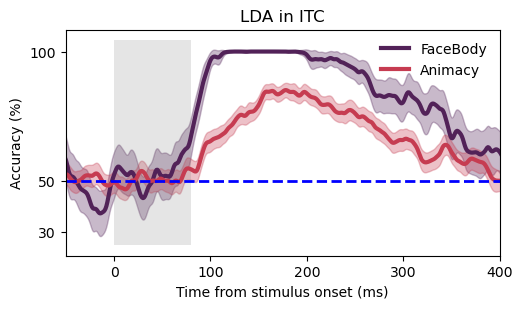

In [ ]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [30,100]
figure_size = np.array((2.5,1.5)) * 2

m_plot([acc_itc_fb,acc_itc_anim], [color_fb,color_anim], error_method='std', 
       smooth_win=smooth_win, labels=['FaceBody','Animacy'], plot_title=f'LDA in ITC', timepoints=time_stamps, figure_size=figure_size)

plt.axhline(50, ls='--', c='b', lw=figure_size[0]*.4)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Accuracy (%)')
# plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], 50, plot_ylim[1]])

# plt.savefig(f'{FigDir}axes_align.svg', dpi=1000)
clear_output()

Text(0.5, 1.0, 'Peak Time for ITC')

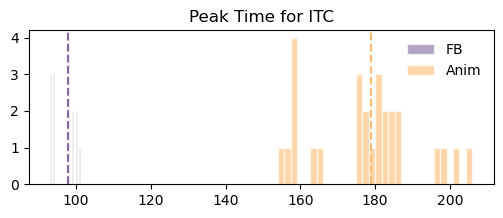

In [27]:
base_time_idx = (time_stamps>-50) & (time_stamps<50)
_, peak_itc_fb, onset_itc_fb, sol_itc_fb, _ = FindResp(acc_itc_fb, time_stamps, base_time_idx)
_, peak_itc_anim, onset_itc_anim, sol_itc_anim, _ = FindResp(acc_itc_anim, time_stamps, base_time_idx)

figure_size=(6,2)
plt.figure(figsize=figure_size)

plot_num = 1
if plot_num==1:
    plt.hist(peak_itc_fb, bins=30, color=color_pfc_n[:3], alpha=.6, label='FB', edgecolor=[1,1,1])
    plt.hist(peak_itc_anim, bins=30, color=color_itc_n[:3], alpha=.6, label='Anim', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(peak_itc_fb), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(peak_itc_anim), ls='--', color=color_itc_n[:3], alpha=1)
    
    # plot_ylim = [0,8]
    plot_title = 'Peak Time'
    
elif plot_num==2:
    plt.hist(onsetsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(onsetsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(onsetsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(onsetsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    plot_ylim = [0,12]
    plot_title = 'Onset Time'
elif plot_num==3:
    plt.hist(solsss_pfc, bins=30, color=color_pfc_n[:3], alpha=.6, label='PFC', edgecolor=[1,1,1])
    plt.hist(solsss_itc, bins=30, color=color_itc_n[:3], alpha=.6, label='ITC', edgecolor=[1,1,1])

    plt.axvline(np.nanmedian(solsss_pfc), ls='--', color=color_pfc_n[:3], alpha=1)
    plt.axvline(np.nanmedian(solsss_itc), ls='--', color=color_itc_n[:3], alpha=1)

    print(wilcoxon(solsss_itc, solsss_pfc, nan_policy='omit'))
    plot_ylim = [0,25]
    plot_title = 'Solution Time'

# plt.ylim(plot_ylim)
# plt.yticks(plot_ylim)

plt.legend(frameon=False)
plt.title(f'{plot_title} for ITC')

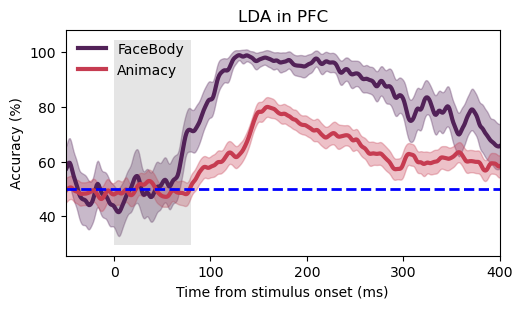

In [ ]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [.4,1.0]
figure_size = np.array((2.5,1.5)) * 2

m_plot([acc_pfc_fb,acc_pfc_anim], [color_fb,color_anim], error_method='std', 
       smooth_win=smooth_win, labels=['FaceBody','Animacy'], plot_title=f'LDA in PFC', timepoints=time_stamps, figure_size=figure_size)

plt.axhline(50, ls='--', c='b', lw=figure_size[0]*.4)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Accuracy (%)')
# plt.ylim(plot_ylim)
# plt.yticks([plot_ylim[0], .5, plot_ylim[1]])

# plt.savefig(f'{FigDir}axes_align.svg', dpi=1000)
clear_output()

([<matplotlib.axis.YTick at 0x2553c757790>,
 [Text(0, 30, '30'), Text(0, 50, '50'), Text(0, 100, '100')])

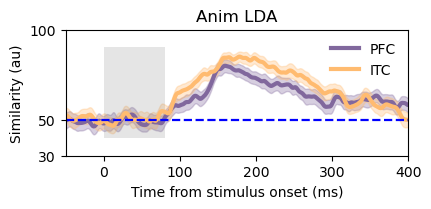

In [37]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [30,100]
figure_size=np.array((4,2)) * 1

m_plot([acc_pfc_anim,acc_itc_anim], [color_pfc,color_itc], error_method='std', 
       smooth_win=smooth_win, labels=['PFC','ITC'], plot_title=f'Anim LDA', timepoints=time_stamps, figure_size=figure_size)

plt.axhline(50, ls='--', c='b', lw=figure_size[0]*.4)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim([plot_xlim[0],plot_xlim[1]])
plt.xticks([0,100,200,300,400])

plt.ylabel('Similarity (au)')
# plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], 50, plot_ylim[1]])

# plt.savefig(f'{FigDir}rsa_{myCond}_both.svg')